# <center> Newman on custom trace and user graph </center>

In [472]:
import util
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

Load trace.

In [473]:
trace_path = "../Datasets/trace_test.txt"

Get authors.

In [474]:
Author = util.get_authors(trace_path)

Get users.

In [475]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [476]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N. We set the number of observation N[i,j] to the number of retweets by j.

/!\ N[i,j] : nb obs for j-->i /!\

/!\ E[i,j] : nb edges observed for j-->i /!\

In [515]:
# init
E = {e:0 for e in node_pairs}
N = {e:0 for e in node_pairs}

# read tweets
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet
    if rtid != -1:
        
#         # update N[.,uid]
#         for user in users.difference({uid}):
#             N[uid, user] += 1
            
        # if retweetd user known update E[rtu,uid]
        if rtid in Author:
            rtu = Author[rtid]
            if rtu != uid: # no self-edges
                E[rtu,uid] = min(E[rtu,uid]+1, 16)
                
N = { e:16 for e in node_pairs}

Reduce the scale of N and E to avoid floats problems.

In [380]:
def scaling(x, I1, I2):
    # scales x from interval I1=[A,B] to I2=[a,b]
    A, B = I1[0], I1[1]
    a, b = I2[0], I2[1]
    return ((b-a)*x + a*B - A*b) / (B-A)

I1 = (min(E.values()), max(N.values()))
I2 = (2,4)
for e in N:
    N[e] = scaling(N[e], I1, I2)
    E[e] = scaling(E[e], I1, I2)
    
# # old scaling
# scaling_factor = min(E.values()) + 1
# for e in N:
#     N[e] /= scaling_factor
#     E[e] /= scaling_factor

In [514]:
print("min E, max E = ", min(E.values()), ",", max(E.values()))

min E, max E =  0 , 16


## 2. Iterations

Choose nb of repetitions and max iterations.

In [516]:
repetitions = 1
max_iter = 1000

Proceed.

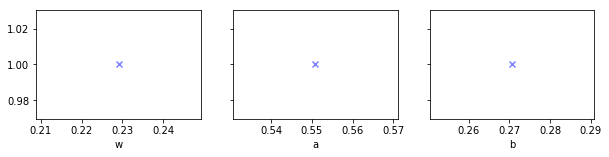

mean value for w : 0.2290350691965735
median value for w : 0.2290350691965735

mean value for a : 0.5508828475558412
median value for a : 0.5508828475558412

mean value for b : 0.2707546007011768
median value for b : 0.2707546007011768



In [522]:
verbose = False

# at each repetition we save the values of w, a and b
results = {'w':list(), 'a':list(), 'b':list()}

for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.random()
        a = random.random()
        b = random.random()
        if verbose:
            print("init values ", w, a, b)
            print()

        # iter
        for l in range(max_iter):

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for (i,j) in node_pairs:
                Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
                Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])
            
            # update w,a,b
            w = sum(Q.values()) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for (i,j) in node_pairs:
                numerator_a += Q[i,j] * E[i,j]
                numerator_b += (1-Q[i,j]) * E[i,j]
                denominator_a += Q[i,j] * N[i,j]
                denominator_b += (1-Q[i,j]) * N[i,j]
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b
            if verbose:
                print(w,a,b)
                print()
            
            # break if no sufficient evolution
            if np.all(np.abs([a-old_a, b-old_b, w-old_w]) < 0.0001):
                if verbose:
                    print(np.abs([a-old_a, b-old_b, w-old_w]))
                break
            
        # add results to results dict
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        
    except e:
        continue

    
# plot the results and compute mean,med
mean = dict()
med = dict()
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    mean[key] = np.mean(values)
    med[key] = np.median(values)
    ax[i].scatter(values, [1]*len(values), marker='x', alpha=.5, linewidths=.01, color='blue', label=key)
    ax[i].set_xlabel(key)
    
plt.show()
plt.close()

# print most probable
for key in results:
    print("mean value for {} : {}".format(key, mean[key]))
    print("median value for {} : {}".format(key, med[key]))
    print()

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

Text(0, 0.5, 'a posteriori edge proba')

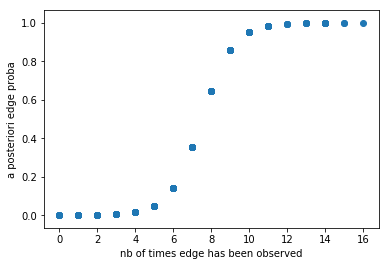

In [547]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot = [E[e] for e in node_pairs]
y2plot = [Q[e] for e in node_pairs]
plt.scatter(x2plot, y2plot)
plt.xlabel("nb of times edge has been observed")
plt.ylabel("a posteriori edge proba")

Get real graph.

In [600]:
G = nx.DiGraph()
G.add_nodes_from(users)

for line in open("../Datasets/leadgraph_test.txt"):
    line = line.split()
    user = int(line[0])
    for leader in line[1:]:
        leader = int(leader)
        G.add_edge(leader, user)

Compare edges in real graph vs their posterior probability.

Text(0, 0.5, 'nb of actual edges')

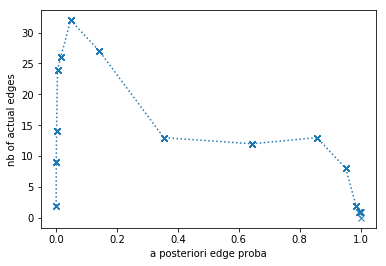

In [601]:
plt.rcParams["figure.figsize"] = [6,4]
real_edges_count = list()
for q in sorted(Q.values()):
    real_edges_count.append(0)
    for e in G.edges:
        if Q[e] == q:
            real_edges_count[-1] += 1
            
plt.plot(sorted(Q.values()), real_edges_count, marker='x', ls=':')
plt.xlabel("a posteriori edge proba")
plt.ylabel("nb of actual edges")

0.00012748389972481932 0.3333333333333333
0.00042099097274934754 0.28205128205128205
0.0013893024989637115 0.20491803278688525
0.004574611977703295 0.22072072072072071
0.014953648342257935 0.2054794520547945
0.04775136620219197 0.21357285429141717
0.14210645069067865 0.21859706362153344
0.3536602254505202 0.21120689655172414
0.6438069840660188 0.21143617021276595
0.8565395495852106 0.21419676214196762
0.9517430852183288 0.21428571428571427
0.984882523345572 0.21411764705882352
0.995374735830943 0.21428571428571427
0.9985952647382115 0.21420256111757857
0.9995743279561281 0.21337946943483277
0.9998710981639855 0.2140391254315305
0.999960974076192 0.21379310344827587


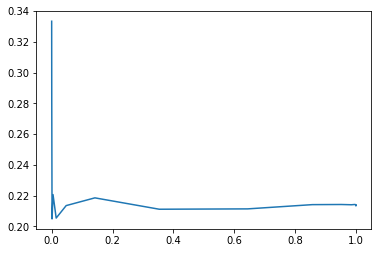

In [614]:
Qval = list(Q.values())
Qval_unique = sorted(set(Qval))
real_edge_prob = list()

for q in Qval_unique:
    real_edge_prob.append(len([e for e in G.edges if Q[e]<=q]) / len([e for e in Q if Q[e]<=q]))
    print(q, real_edge_prob[-1])
    
plt.plot(Qval_unique, real_edge_prob)

(array([5.79043785, 1.24289701, 0.        , 0.96507297, 0.        ,
        0.        , 0.68724894, 0.        , 0.54102576, 0.77498284]),
 array([1.27483900e-04, 1.00110833e-01, 2.00094182e-01, 3.00077531e-01,
        4.00060880e-01, 5.00044229e-01, 6.00027578e-01, 7.00010927e-01,
        7.99994276e-01, 8.99977625e-01, 9.99960974e-01]),
 <a list of 10 Patch objects>)

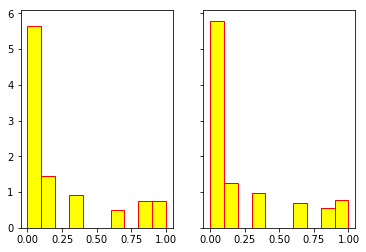

In [596]:
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].hist([Q[e] for e in G.edges], density=True, facecolor='yellow', edgecolor='red')
ax[1].hist([Q[e] for e in node_pairs if e not in G.edges], density=True, facecolor='yellow', edgecolor='red')

Estimate $\omega$ from real graph and get real values of $a,b$.

In [581]:
w_estimated_from_real_graph = G.number_of_edges() / (2*binom(n,2))
print("estimated w from real graph = ", w_estimated_from_real_graph)

a_numerator, a_denominator = 0, 0
for e in G.edges:
    a_numerator += E[e]
    a_denominator += N[e]
print("real a = ", a_numerator/a_denominator)

b_numerator, b_denominator = 0, 0
for e in node_pairs:
    if e not in G.edges:
        b_numerator += E[e]
        b_denominator += N[e]
print("real b = ", b_numerator/b_denominator)

estimated w from real graph =  0.21379310344827587
real a =  0.3343413978494624
real b =  0.3350694444444444


Compare expected degrees.

In [527]:
print("Expected degree observed : {} with variance ={}".format(2*sum(Q.values())/n, "?"))
print("Real expected degree : ", np.mean(G.degree()))

Expected degree observed : 13.284034013401262 with variance =?
Real expected degree :  13.45


### 3.2 Sample generation

We generate a sample graph according to the posterior distribution.

Q[i,j] = proba of edge j-->i.

In [435]:
G_sample = nx.DiGraph()
G_sample.add_nodes_from(users)

for e in node_pairs:
    if random.random() < Q[e]:
        G_sample.add_edge(e[1], e[0])

Compare real graph with sample.

In [437]:
sampled_edges_in_real = set()
real_edges_in_sample = set()

for e in G_sample.edges:
    if e in G.edges:
        sampled_edges_in_real.add(e)

for e in G.edges:
    if e in G_sample.edges:
        real_edges_in_sample.add(e)
        
print("Proportion of edges from real graph in sample : ", len(real_edges_in_sample)/G_real.number_of_edges())
print("Proportion of edges from sample in real graph : ", len(sampled_edges_in_real)/G_sample.number_of_edges())

Proportion of edges from real graph in sample :  0.4821917808219178
Proportion of edges from sample in real graph :  0.14902624894157493
